In [1]:
# Homework #3 (Fall 2019, UA Geology, Geostatistics)
# Written by Jonathan Frame for the coding academy workshop.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from pylab import cm
from matplotlib import colors as mcol

from netCDF4 import Dataset as NetCDFFile
#from mpl_toolkits.basemap import Basemap

In [3]:
# locate the data
dataDir = '/Users/jf/Box Sync/class/geostat/data/'
dataName = 'camels_all_coding_workshop.csv'
dataLoc = dataDir + dataName
# load the data with pandas
pd_data = pd.read_csv(dataLoc, sep=',', index_col='gauge_id')

In [4]:
# Remove any rows with nan
pd_data = pd_data.dropna()

In [5]:
pd_data.columns.values

array(['q_mean', 'runoff_ratio', 'slope_fdc', 'baseflow_index',
       'stream_elas', 'q5', 'q95', 'high_q_freq', 'high_q_dur',
       'low_q_freq', 'low_q_dur', 'zero_q_freq', 'hfd_mean',
       'geol_1st_class', 'glim_1st_class_frac', 'carbonate_rocks_frac',
       'geol_porostiy', 'geol_permeability', 'p_mean', 'pet_mean',
       'p_seasonality', 'frac_snow', 'aridity', 'high_prec_freq',
       'high_prec_dur', 'high_prec_timing', 'low_prec_freq',
       'low_prec_dur', 'low_prec_timing', 'gauge_lat', 'gauge_lon',
       'elev_mean', 'area_gages2', 'area_geospa_fabric',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'max_water_content',
       'sand_frac', 'silt_frac', 'clay_frac', 'water_frac',
       'organic_frac', 'other_frac', 'frac_forest', 'lai_max', 'gvf_max',
       'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50',
       'root_depth_99'], dtype=object)

In [115]:
X=np.array(pd_data.loc[:,['gauge_lat','gauge_lon']])
y=np.array(pd_data['q_mean'])

In [116]:
X

array([[ 4.4607970e+01, -6.7935240e+01,  3.6081260e+00,  5.8735600e-01,
        -1.1453000e-01],
       [ 4.5175010e+01, -6.9314700e+01,  3.5229570e+00,  5.8795000e-01,
         1.0409100e-01],
       [ 4.4869200e+01, -6.9955100e+01,  3.3231460e+00,  6.2892900e-01,
         1.4777600e-01],
       ...,
       [ 4.2891500e+01, -1.2407065e+02,  6.2974370e+00,  3.8661000e-01,
        -9.5205500e-01],
       [ 4.2154010e+01, -1.2307532e+02,  2.7816760e+00,  1.1953900e+00,
        -9.8548600e-01],
       [ 4.2123440e+01, -1.2418731e+02,  5.5560710e+00,  4.1030200e-01,
        -1.0159460e+00]])

In [117]:
# SET UP K-FOLD
# Split into training groups
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

10

0.3530822576648331
0.4717561243429507
0.28481361696903956
0.5102233223444511
0.5631170310143953
0.18793556374194978
0.26031089362325555
0.2911026943721729
0.41316284358392497
0.30127593815651915


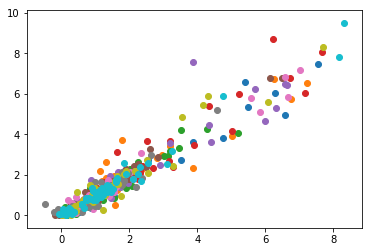

In [118]:
# GPR (Kriging) in a K-fold loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, \
                                   n_restarts_optimizer=15, \
                                   alpha=0.1, normalize_y=True)
    gpr.fit(X_train, y_train)
    
    y_hat = gpr.predict(X_test, return_std=False) 
    rmse = np.sqrt(np.mean((y_test - y_hat)**2))

    plt.scatter(y_hat,y_test)
    print(rmse)

In [119]:
# Train the model on all the data for plotting.
X_krig=np.array(pd_data.loc[:,['gauge_lat','gauge_lon']])
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, \
                               alpha=0.3, normalize_y=True)
gpr.fit(X_krig, y)

GaussianProcessRegressor(alpha=0.3, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=15,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [120]:
maskName = 'NLDAS_IGBPpredomveg.asc'
maskLoc = dataDir + maskName
km2 = np.genfromtxt(maskLoc)[:,4]
waterMask = np.genfromtxt(maskLoc)[:,21]
for i in range(km2.shape[0]):
    if waterMask[i] > km2[i]/2:
        waterMask[i] = 'NaN'
    elif waterMask[i] <= km2[i]/2:
        waterMask[i] = 1
waterMask = np.reshape(waterMask,[224,464], order='A') #options are CFA
print(waterMask.shape)

(224, 464)


In [121]:
# grid corners
Nlat =  52.9375
Elon = -67.0625
Slat =  25.0625
Wlon = -124.9375
# grid spacing
delta = 0.125
nlons = int((Elon-Wlon)/delta)
nlats = int((Nlat-Slat)/delta)
lats = np.linspace(Slat,Nlat,nlats, endpoint=False)
lons = np.linspace(Wlon,Elon,nlons, endpoint=False)
z = np.zeros([nlats,nlons])
xv, yv = np.meshgrid(lons, lats)
for lon in range(nlons):
    for lat in range(nlats):
        if waterMask[lat,lon] == 1:
            z[lat,lon] = gpr.predict([[lats[lat],lons[lon]]], return_std=False)
        else:
            z[lat,lon] = 'NaN'

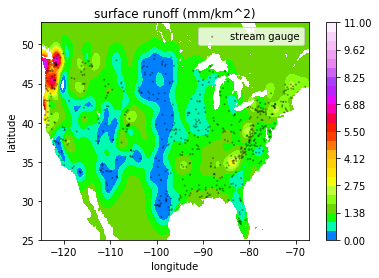

In [144]:
fig, ax1 = plt.subplots()
colorbins = np.linspace(0,11,num=25)
norm=mcol.PowerNorm(gamma=0.5)
colorscale = ax1.contourf(xv, yv, z, colorbins, norm=norm, cmap=plt.cm.gist_ncar)
cbar = fig.colorbar(colorscale)
plt.scatter(pd_data['gauge_lon'],pd_data['gauge_lat'], \
            s=1, facecolors='none', alpha=0.4,edgecolors='black', label='stream gauge')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.title('surface runoff (mm/km^2)')
plt.show()